In [1]:
import tensorflow as tf
import numpy as np
from collections import Counter
from Util import batch_renorm, batch_norm
import matplotlib.pyplot as plt
from PIL import Image
import os

C:\Users\CSH\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_wd = 'C:\\Users\\CSH\\Desktop\\image_example\\train\\'
test_wd = 'C:\\Users\\CSH\\Desktop\\image_example\\test\\'
resizing=(32,32)

train_x = np.empty([1,32,32,3])
train_y = np.empty(1)
idx=0
for path, dir, files in os.walk(train_wd):
    if path == train_wd:
        ch_to_idx = {idx:t for idx,t in enumerate(dir)}
        continue
    for file in files[:50]:
        image_dir = path + '/' + file 
        img = Image.open(image_dir)
        img = img.resize(resizing)
        if not img.format == "RGB": # 이미지의 포맷이 RGB가 아닐 경우, RGB로 convert 시킴
            img = img.convert("RGB")
        train_x = np.vstack([train_x, np.array(img).reshape([1,32,32,3])])
        train_y = np.vstack([train_y, idx])
    idx+=1

In [3]:
test_x = np.empty([1,32,32,3])
test_y = np.empty(1)
idx=0
for path, dir, files in os.walk(test_wd):
    if path == test_wd:
        ch_to_idx = {idx:t for idx,t in enumerate(dir)}
        continue
    for file in files:
        image_dir = path + '/' + file 
        img = Image.open(image_dir)
        img = img.resize(resizing)
        if not img.format == "RGB": # 이미지의 포맷이 RGB가 아닐 경우, RGB로 convert 시킴
            img = img.convert("RGB")
        test_x = np.vstack([test_x, np.array(img).reshape([1,32,32,3])])
        test_y = np.vstack([test_y, idx])
    idx+=1

In [4]:
train_x = train_x[1:]
train_y = train_y[1:]
test_x = test_x[1:]
test_y = test_y[1:]

train_y = train_y.astype(int)
train_y = train_y.reshape(-1)
test_y = test_y.astype(int)
test_y = test_y.reshape(-1)

In [5]:
print(np.shape(train_x))
print(np.shape(train_y))
print(np.shape(test_x))
print(np.shape(test_y))

(200, 32, 32, 3)
(200,)
(84, 32, 32, 3)
(84,)


In [6]:
ch_to_idx

{0: 'bicycle', 1: 'horse', 2: 'ship', 3: 'truck'}

### CNN Without BatchNorm 

In [44]:
train_graph_1 = tf.Graph()
with train_graph_1.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 32,32,3])
    y = tf.placeholder(tf.int32, shape=[None])
    y_onehot = tf.one_hot(y, depth=4)
    
    w = tf.get_variable(shape = [3,3,3,32], name='w')
    w_softmax = tf.get_variable(shape = [16*16*32,4], name='w_softmax')
    b_softmax = tf.get_variable(shape = [4], name = 'b_softmax')
    
    layer = tf.nn.conv2d(filter=w, input=x, padding='SAME', strides=[1,1,1,1])
    # batch normal x
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], padding='SAME', strides=[1,2,2,1])
    
    logit = tf.matmul(tf.reshape(layer, shape=[-1,16*16*32]), w_softmax) + b_softmax
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=y_onehot))
    training = tf.train.GradientDescentOptimizer(0.000001).minimize(loss) # gradientoptimizer로하니까 학습 거의안됨 .. lr을 엄청나게 낮춰야되는구나 
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.argmax(logit, 1),dtype=tf.float32), tf.cast(y,dtype=tf.float32)), dtype=tf.float32))

In [45]:
batch_size = 4
n_epoch=15
acc_list=[]

In [46]:
with tf.Session(graph=train_graph_1) as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epoch) :
        batch_start=0
        total_idx = np.arange(len(train_x)) ; #np.random.shuffle(total_idx)
        for _ in range(int(np.ceil(len(train_x)/batch_size))):
            batch_idx = total_idx[batch_start:batch_start+batch_size]
            batch_x = train_x[total_idx]
            batch_y = train_y[total_idx]
            sess.run(training, feed_dict={x:batch_x,
                                          y:batch_y})
            batch_start += batch_size
        print('------------------------------------------- Epoch : {} -----------------------------------------------------' .format(epoch))
        print('Loss : ', sess.run(loss, feed_dict={x:batch_x,
                                                   y:batch_y}))
        print('Train Accuracy : ', sess.run(acc, feed_dict={x:batch_x,
                                                          y:batch_y}))
        accuracy = sess.run(acc, feed_dict={x:test_x,
                                              y:test_y})
        print('Test Accuracy : ', accuracy)
        acc_list.append(accuracy)

------------------------------------------- Epoch : 0 -----------------------------------------------------
Loss :  119.52539
Train Accuracy :  0.855
Test Accuracy :  0.63095236
------------------------------------------- Epoch : 1 -----------------------------------------------------
Loss :  38.826393
Train Accuracy :  0.95
Test Accuracy :  0.63095236
------------------------------------------- Epoch : 2 -----------------------------------------------------
Loss :  18.437176
Train Accuracy :  0.975
Test Accuracy :  0.64285713
------------------------------------------- Epoch : 3 -----------------------------------------------------
Loss :  11.084818
Train Accuracy :  0.99
Test Accuracy :  0.64285713
------------------------------------------- Epoch : 4 -----------------------------------------------------
Loss :  7.7499285
Train Accuracy :  0.995
Test Accuracy :  0.64285713
------------------------------------------- Epoch : 5 -----------------------------------------------------
Loss

### CNN With BatchNorm

In [64]:
from tensorflow.python import control_flow_ops

In [66]:
train_graph_2 = tf.Graph()
with train_graph_2.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 32,32,3])
    y = tf.placeholder(tf.int32, shape=[None])
    y_onehot = tf.one_hot(y, depth=4)
    phase_train = tf.placeholder(tf.bool)

    w = tf.get_variable(shape = [3,3,3,32], name='w')
    w_softmax = tf.get_variable(shape = [16*16*32,4], name='w_softmax')
    b_softmax = tf.get_variable(shape = [4], name = 'b_softmax')

    layer = tf.nn.conv2d(filter=w, input=x, padding='SAME', strides=[1,1,1,1])
    layer = batch_norm(layer, n_out=32, phase_train = phase_train)

    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], padding='SAME', strides=[1,2,2,1])

    logit = tf.matmul(tf.reshape(layer, shape=[-1,16*16*32]), w_softmax) + b_softmax
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=y_onehot))
    training = tf.train.GradientDescentOptimizer(0.000001).minimize(loss) # gradientoptimizer로하니까 학습 거의안됨 .. lr을 엄청나게 낮춰야되는구나 
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.argmax(logit, 1),dtype=tf.float32), tf.cast(y,dtype=tf.float32)), dtype=tf.float32))

In [67]:
batch_size = 4
n_epoch=15
acc_list_2=[]

In [68]:
with tf.Session(graph=train_graph_2) as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epoch) :
        batch_start=0
        total_idx = np.arange(len(train_x)) ;# np.random.shuffle(total_idx)
        for _ in range(int(np.ceil(len(train_x)/batch_size))):
            batch_idx = total_idx[batch_start:batch_start+batch_size]
            batch_x = train_x[total_idx]
            batch_y = train_y[total_idx]
            sess.run(training, feed_dict={x:batch_x,
                                          y:batch_y,
                                         phase_train:True})
            batch_start += batch_size
        print('------------------------------------------- Epoch : {} -----------------------------------------------------' .format(epoch))
        print('Loss : ', sess.run(loss, feed_dict={x:batch_x,
                                                   y:batch_y,
                                                phase_train:False}))
        print('Train Accuracy : ', sess.run(acc, feed_dict={x:batch_x,
                                                            y:batch_y,
                                                            phase_train:False}))
        accuracy = sess.run(acc, feed_dict={x:test_x,
                                            y:test_y,
                                            phase_train:False})
        print('Test Accuracy : ', accuracy)
        acc_list_2.append(accuracy)

------------------------------------------- Epoch : 0 -----------------------------------------------------
Loss :  220.12291
Train Accuracy :  0.51
Test Accuracy :  0.5714286
------------------------------------------- Epoch : 1 -----------------------------------------------------
Loss :  182.89407
Train Accuracy :  0.645
Test Accuracy :  0.60714287
------------------------------------------- Epoch : 2 -----------------------------------------------------
Loss :  158.04329
Train Accuracy :  0.7
Test Accuracy :  0.63095236
------------------------------------------- Epoch : 3 -----------------------------------------------------
Loss :  139.70285
Train Accuracy :  0.76
Test Accuracy :  0.6785714
------------------------------------------- Epoch : 4 -----------------------------------------------------
Loss :  125.375
Train Accuracy :  0.785
Test Accuracy :  0.6904762
------------------------------------------- Epoch : 5 -----------------------------------------------------
Loss :  113

### CNN With BatchRenorm

In [72]:
train_graph_3 = tf.Graph()
with train_graph_3.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 32,32,3])
    y = tf.placeholder(tf.int32, shape=[None])
    y_onehot = tf.one_hot(y, depth=4)
    phase_train = tf.placeholder(tf.bool)
    r_max = tf.placeholder(tf.float32, shape=[]) # scalar는 shape을 이렇게 비워야 함
    d_max = tf.placeholder(tf.float32, shape=[])

    w = tf.get_variable(shape = [3,3,3,32], name='w')
    w_softmax = tf.get_variable(shape = [16*16*32,4], name='w_softmax')
    b_softmax = tf.get_variable(shape = [4], name = 'b_softmax')

    layer = tf.nn.conv2d(filter=w, input=x, padding='SAME', strides=[1,1,1,1])
    layer = batch_norm(layer, n_out=32, phase_train = phase_train)
    layer = batch_renorm(layer, n_out=32, phase_train = phase_train, r_max=r_max, d_max=d_max)

    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], padding='SAME', strides=[1,2,2,1])

    logit = tf.matmul(tf.reshape(layer, shape=[-1,16*16*32]), w_softmax) + b_softmax
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=y_onehot))
    training = tf.train.GradientDescentOptimizer(0.000001).minimize(loss) # gradientoptimizer로하니까 학습 거의안됨 .. lr을 엄청나게 낮춰야되는구나 
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.argmax(logit, 1),dtype=tf.float32), tf.cast(y,dtype=tf.float32)), dtype=tf.float32))

In [73]:
batch_size = 4
n_epoch=15
acc_list_3=[]

In [74]:
with tf.Session(graph=train_graph_3) as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epoch) :
        batch_start=0
        total_idx = np.arange(len(train_x)) #; np.random.shuffle(total_idx)
        r_max_value = 1
        d_max_value = 0
        for iteration in range(int(np.ceil(len(train_x)/batch_size))):
            batch_idx = total_idx[batch_start:batch_start+batch_size]
            batch_x = train_x[total_idx]
            batch_y = train_y[total_idx]
            if epoch > n_epoch/3:
                r_max_value = 1 + 0.1 * epoch
                d_max_value = 0.1 * epoch
            sess.run(training, feed_dict={x:batch_x,
                                          y:batch_y,
                                         phase_train:True,
                                         r_max : r_max_value,
                                         d_max : d_max_value})
            batch_start += batch_size
        print('------------------------------------------- Epoch : {} -----------------------------------------------------' .format(epoch))
        print('Loss : ', sess.run(loss, feed_dict={x:batch_x,
                                                   y:batch_y,
                                                   phase_train:False,
                                                 r_max : r_max_value,
                                                 d_max : d_max_value}))
        print('Train Accuracy : ', sess.run(acc, feed_dict={x:batch_x,
                                                            y:batch_y,
                                                            phase_train:False,
                                                         r_max : r_max_value,
                                                         d_max : d_max_value}))
        accuracy = sess.run(acc, feed_dict={x:test_x,
                                            y:test_y,
                                            phase_train:False,
                                             r_max : r_max_value,
                                             d_max : d_max_value})
        print('Test Accuracy : ', accuracy)
        acc_list_3.append(accuracy)

------------------------------------------- Epoch : 0 -----------------------------------------------------
Loss :  196.177
Train Accuracy :  0.605
Test Accuracy :  0.53571427
------------------------------------------- Epoch : 1 -----------------------------------------------------
Loss :  161.82492
Train Accuracy :  0.7
Test Accuracy :  0.61904764
------------------------------------------- Epoch : 2 -----------------------------------------------------
Loss :  139.3371
Train Accuracy :  0.76
Test Accuracy :  0.6785714
------------------------------------------- Epoch : 3 -----------------------------------------------------
Loss :  122.76203
Train Accuracy :  0.82
Test Accuracy :  0.6904762
------------------------------------------- Epoch : 4 -----------------------------------------------------
Loss :  109.919174
Train Accuracy :  0.85
Test Accuracy :  0.75
------------------------------------------- Epoch : 5 -----------------------------------------------------
Loss :  99.573616

### Comparison between None, Batch Norm, Batch Renorm

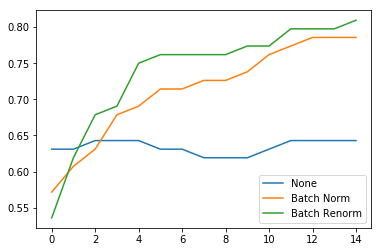

In [77]:
# mini-batch, non-iid. decay ratio = 0.9
plt.plot(acc_list)
plt.plot(acc_list_2)
plt.plot(acc_list_3)
plt.legend(['None', 'Batch Norm', 'Batch Renorm'])
plt.show()